In [1]:
import time
import math, os

from coffea.nanoevents import BaseSchema

import awkward as ak
import numpy as np
from coffea import processor

from hist import Hist

from coffea.nanoevents.methods import candidate
ak.behavior.update(candidate.behavior)

import matplotlib.pyplot as plt

In [2]:
gen_part_cols = ['GenPart_eta', 'GenPart_mass', 'GenPart_pdgId', "GenPart_phi", "GenPart_pt", 'GenPart_status', 'GenPart_charge',
                 'GenPart_numberOfDaughters', 'GenPart_vx', 'GenPart_vy', 'GenPart_vz', 'GenPart_genPartIdxMother']

muon_cols = ['Muon_charge', 'Muon_dxy', 'Muon_dxyErr', 'Muon_dz', 'Muon_dzErr', 'Muon_eta', 'Muon_isGlobal', 'Muon_mass',
             'Muon_phi', 'Muon_pt', 'Muon_ptErr', 'Muon_softId', 'Muon_vtxIdx', 'Muon_vtxFlag', 'Muon_simIdx']

dimu_cols = ['Dimu_pt', 'Dimu_eta', 'Dimu_phi', 'Dimu_rap', 'Dimu_mass', 'Dimu_charge', 'Dimu_vtxIdx', 'Dimu_chi2', 'Dimu_dl',
             'Dimu_dlErr', 'Dimu_dlSig', 'Dimu_cosphi', 'Dimu_x', 'Dimu_y', 'Dimu_z', 'Dimu_t1muIdx', 'Dimu_t2muIdx',]

D0_PDG_MASS = 1.864

def get_vars_dict(events, col_list):
    dict = {}
    col = ''
    for c in col_list:
        col = c[c.find("_")+1:]
        if len(events[c]) == 0:
            dict[col] = np.array([])
        else:
            dict[col] = events[c]
    return dict

def make_acceptance_plot(fig, hist_reco, hist_gen):
    fig.clear()
    ax = fig.add_subplot()
    acceptance_plot(hist_reco, hist_gen, ax=ax)
    labels = [axis.label.replace('Reco ', '') for axis in hist_reco.axes]
    ax.set_xlabel(labels[0])
    ax.set_ylabel(labels[1])

def fill_hists(hists, candidate, get_deltam=False):
    hists['pt'].fill(pt=ak.flatten(candidate.pt))
    hists['eta'].fill(eta=ak.flatten(candidate.eta))
    hists['phi'].fill(phi=ak.flatten(candidate.phi))
    if get_deltam:
        hists['deltam'].fill(deltam=ak.flatten(candidate.deltamr))
    else:
        hists['mass'].fill(mass=ak.flatten(candidate.mass))
    hists['ptxeta'].fill(
        pt=ak.flatten(candidate.pt),
        eta=ak.flatten(candidate.eta)
        )
    hists['ptxmodeta_0-10'].fill(
        pt=ak.flatten(candidate.pt),
        modeta=ak.flatten(candidate.modeta)
        )
    hists['ptxmodeta_0-100'].fill(
        pt=ak.flatten(candidate.pt),
        modeta=ak.flatten(candidate.modeta)
        )
    hists['ptxmodeta_var'].fill(
        pt=ak.flatten(candidate.pt),
        modeta=ak.flatten(candidate.modeta)
        )

def build_4mom_string(candidate):
    return f'({candidate.pt:.2f},{candidate.eta:.2f},{candidate.phi:.2f},{candidate.mass:.2f})'

def to_cartesian(cand):
    x = cand.pt*math.cos(cand.phi)
    y = cand.pt*math.sin(cand.phi)
    z = cand.pt*math.sinh(cand.eta)
    t = math.sqrt(x*x + y*y + z*z + cand.mass*cand.mass)

    return t, x, y, z

def sum_cand(cand1, cand2):
    t1, x1, y1, z1 = to_cartesian(cand1)
    t2, x2, y2, z2 = to_cartesian(cand2)

    tr = t1+t2
    xr = x1+x2
    yr = y1+y2
    zr = z1+z2

    r = math.sqrt(xr*xr + yr*yr + zr*zr)
    pt = math.sqrt(xr*xr + yr*yr)
    eta = math.asinh(zr / r)
    phi = math.atan2(yr, xr)
    mass = math.sqrt(tr*tr - xr*xr - yr*yr - zr*zr)

    return f'({pt:.2f},{eta:.2f},{phi:.2f},{mass:.2f})'


def print_candidate(candidate):
    quadrimom = build_4mom_string(candidate)
    print(f"PDGId: {candidate.pdgId}, motherId: {candidate.genPartIdxMother}, n_daughters: {candidate.numberOfDaughters}, status: {candidate.status}, 4-momentum (pt, eta, phi, mass): {quadrimom}")

In [3]:
import re

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

paths = [
    '/eos/user/k/kmotaama/CRAB_UserFiles/UpsilonPtGun/220110_105728/0000/',
    '/eos/user/k/kmotaama/CRAB_UserFiles/UpsilonPtGun/220110_105728/0001/',
    ]

files = []
for path in paths:
    with os.scandir(path) as it:
        for file in it:
            if file.name.endswith('.root') and (file.stat().st_size != 0):
                files.append(file.path)

In [23]:
import matplotlib.pyplot as plt
import mplhep
from matplotlib.text import Text
from hist.intervals import ratio_uncertainty
plt.style.use(mplhep.style.CMS)
    
plt.rcParams.update({
    'font.size': 16,
    'axes.titlesize': 18,
    'axes.labelsize': 18,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14
})

def create_plot1d(hist1d, log=False, ax=None, lumi=None):
    from matplotlib.offsetbox import AnchoredOffsetbox, TextArea

    hist1d.plot1d(ax=ax, fill=True, ec=(0,0,0,0.5))
    
    if not lumi == None:
        lumi = plt.text(1., 1., lumi + r" fb$^{-1}$ (13 TeV)",
                        fontsize=18,
                        horizontalalignment='right',
                        verticalalignment='bottom',
                        transform=ax.transAxes
                       )
    
    if log:
        ax.set_yscale('log')
        ax.set_ylim(1, None)
    else:
        ax.ticklabel_format(axis='y', style='sci', scilimits=(0,3), useMathText=True)
    
    centers = hist1d.axes.centers[0]
    values = hist1d.values()
    
    # compute mean and std:
    mean = np.sum(values*centers)/np.sum(values)
    std = np.sqrt(np.sum(values*((centers - mean)**2))/np.sum(values))
    
    annotation = TextArea(f"Total: {np.sum(values):.2e}" \
                    + "\n" + f"Mean: {mean:.2e}" \
                    + "\n" + f"Std: {std:.2e}", textprops=dict(size=14))
    
    at = AnchoredOffsetbox('upper right', child=annotation)
    at.patch.set_facecolor('None')
    ax.add_artist(at)
    
    return ax

def create_plot2d(hist2d, ax):
    plt.style.use(mplhep.style.CMS)
        
    hist2d.plot2d(ax=ax)
    
    return ax

def acceptance_plot(hist_reco, hist_gen, ax=None, with_labels=True):

    ratio = hist_reco / hist_gen.values()

    x, y = len(reco_upsilon.axes[0].centers), len(reco_upsilon.axes[1].centers)

    if with_labels:
        err_down, err_up = ratio_uncertainty(hist_reco.values(), hist_gen.values())
        labels = []
        for ra, u, d in zip(ratio.values().ravel(), err_up.ravel(), err_down.ravel()):
            ra, u, d = f'{ra:.2f}', f'{u:.2f}', f'{d:.2f}'
            st = '$'+ra+'_{-'+d+'}^{+'+u+'}$'
            labels.append(st)
        labels = np.array(labels).reshape(x,y)

        mplhep.hist2dplot(ratio, labels=labels, ax=ax)

        x = ax.get_children()
        for i0 in x:
            if isinstance(i0, Text):
                i0.set_size(10)

        return ax
    else:
        mplhep.hist2dplot(ratio, ax=ax)
        return ax

In [7]:
class AcceptanceProcessor(processor.ProcessorABC):
    def __init__(self):
        Gen_Upsilon_hists = processor.dict_accumulator({
            'Gen_Upsilon_pt': Hist.new.Regular(100, 0, 100, name='pt', label=r"$p_{T,Gen \Upsilon}$ [GeV]").Double(),
            'Gen_Upsilon_eta': Hist.new.Regular(60, -4, 4, name="eta", label=r"$\eta_{Gen \Upsilon}$").Double(),
            'Gen_Upsilon_pt_var': Hist.new.Variable([0, 2, 4, 8, 12, 18, 25, 35, 50], name='pt', label=r"$p_{T,Gen \Upsilon}$ [GeV]").Double(),
            'Gen_Upsilon_modeta': Hist.new.Variable([0, 0.8, 1.2, 2.1, 2.4, 3.2, 4.0], name='modeta', label=r"$|\eta_{Gen \Upsilon}|").Double(),
            'Gen_Upsilon_phi': Hist.new.Regular(60, -math.pi, math.pi, name="phi", label=r"$\phi_{Gen \Upsilon}$").Double(),
            'Gen_Upsilon_mass': Hist.new.Regular(100, 8.6, 11, name="mass", label=r"$m_{Gen \Upsilon}$ [GeV]").Double(),
            'Gen_Upsilon_ptxeta': (
                Hist.new
                .Regular(10, 0, 100, name='pt', label=r"$p_{T,Gen \Upsilon}$ [GeV]")
                .Regular(10, -4, 4, name="eta", label=r"$\eta_{Gen \Upsilon}$")
                .Double()
                ),
            'Gen_Upsilon_ptxmodeta': (
                Hist.new
                .Variable([0, 4, 8, 12, 18, 25, 35, 50], name='pt', label=r"$p_{T,Gen \Upsilon}$ [GeV]")
                .Variable([0, 0.8, 1.2, 2.1, 2.4, 3.2, 4.0], name='modeta', label=r"$|\eta_{Gen \Upsilon}|")
                .Double()
                ),
        })

        Gen_Muon_lead_hists = processor.dict_accumulator({
            'Gen_Muon_lead_pt': Hist.new.Regular(100, 0, 100, name='pt', label=r"$p_{T,Gen \mu}$ [GeV]").Double(),
            'Gen_Muon_lead_eta': Hist.new.Regular(60, -2.5, 2.5, name="eta", label=r"$\eta_{Gen \mu}$").Double(),
            'Gen_Muon_lead_phi': Hist.new.Regular(60, -math.pi, math.pi, name="phi", label=r"$\phi_{Gen \mu}$").Double(),
            'Gen_Muon_lead_mass': Hist.new.Regular(100, 0, 1, name="mass", label=r"$m_{Gen \mu}$ [GeV]").Double(),
            'Gen_Muon_lead_ptxeta': (
                Hist.new
                .Regular(10, 0, 100, name='pt', label=r"$p_{T,Gen \mu}$ [GeV]")
                .Regular(10, -2.5, 2.5, name="eta", label=r"$\eta_{Gen \mu}$")
                .Double()
                ),
        })

        Gen_Muon_trail_hists = processor.dict_accumulator({
            'Gen_Muon_trail_pt': Hist.new.Regular(100, 0, 100, name='pt', label=r"$p_{T,Gen \mu}$ [GeV]").Double(),
            'Gen_Muon_trail_eta': Hist.new.Regular(60, -2.5, 2.5, name="eta", label=r"$\eta_{Gen \mu}$").Double(),
            'Gen_Muon_trail_phi': Hist.new.Regular(60, -math.pi, math.pi, name="phi", label=r"$\phi_{Gen \mu}$").Double(),
            'Gen_Muon_trail_mass': Hist.new.Regular(100, 0, 1, name="mass", label=r"$m_{Gen \mu}$ [GeV]").Double(),
            'Gen_Muon_trail_ptxeta': (
                Hist.new
                .Regular(10, 0, 100, name='pt', label=r"$p_{T,Gen \mu}$ [GeV]")
                .Regular(10, -2.5, 2.5, name="eta", label=r"$\eta_{Gen \mu}$")
                .Double()
                ),
        })

        Reco_Upsilon_hists = processor.dict_accumulator({
            'Reco_Upsilon_pt': Hist.new.Regular(100, 0, 100, name='pt', label=r"$p_{T,Reco \Upsilon}$ [GeV]").Double(),
            'Reco_Upsilon_eta': Hist.new.Regular(60, -5, 5, name="eta", label=r"$\eta_{Reco \Upsilon}$").Double(),
            'Reco_Upsilon_pt_var': Hist.new.Variable([0, 2, 4, 8, 12, 18, 25, 35, 50], name='pt', label=r"$p_{T,Reco \Upsilon}$ [GeV]").Double(),
            'Reco_Upsilon_modeta': Hist.new.Variable([0, 0.8, 1.2, 2.1, 2.4, 3.2, 4.0], name='modeta', label=r"$|\eta_{Reco \Upsilon}|").Double(),
            'Reco_Upsilon_phi': Hist.new.Regular(60, -math.pi, math.pi, name="phi", label=r"$\phi_{Reco \Upsilon}$").Double(),
            'Reco_Upsilon_mass': Hist.new.Regular(100, 8.6, 11, name="mass", label=r"$m_{Reco \Upsilon}$ [GeV]").Double(),
            'Reco_Upsilon_ptxeta': (
                Hist.new
                .Regular(10, 0, 100, name='pt', label=r"$p_{T,Reco \Upsilon}$ [GeV]")
                .Regular(10, -4, 4, name="eta", label=r"$\eta_{Reco \Upsilon}$")
                .Double()
                ),
            'Reco_Upsilon_ptxmodeta': (
                Hist.new
                .Variable([0, 4, 8, 12, 18, 25, 35, 50], name='pt', label=r"$p_{T,Reco \Upsilon}$ [GeV]")
                .Variable([0, 0.8, 1.2, 2.1, 2.4, 3.2, 4.0], name='modeta', label=r"$|\eta_{Reco \Upsilon}|")
                .Double()
                ),
        })

        Reco_Muon_lead_hists = processor.dict_accumulator({
            'Reco_Muon_lead_pt': Hist.new.Regular(100, 0, 100, name='pt', label=r"$p_{T,Reco \mu}$ [GeV]").Double(),
            'Reco_Muon_lead_eta': Hist.new.Regular(60, -2.5, 2.5, name="eta", label=r"$\eta_{Reco \mu}$").Double(),
            'Reco_Muon_lead_phi': Hist.new.Regular(60, -math.pi, math.pi, name="phi", label=r"$\phi_{Reco \mu}$").Double(),
            'Reco_Muon_lead_mass': Hist.new.Regular(100, 0, 1, name="mass", label=r"$m_{Reco \mu}$ [GeV]").Double(),
            'Reco_Muon_lead_ptxeta': (
                Hist.new
                .Regular(10, 0, 100, name='pt', label=r"$p_{T,Reco \mu}$ [GeV]")
                .Regular(10, -2.5, 2.5, name="eta", label=r"$\eta_{Reco \mu}$")
                .Double()
                ),
        })

        Reco_Muon_trail_hists = processor.dict_accumulator({
            'Reco_Muon_trail_pt': Hist.new.Regular(100, 0, 100, name='pt', label=r"$p_{T,Reco \mu}$ [GeV]").Double(),
            'Reco_Muon_trail_eta': Hist.new.Regular(60, -2.5, 2.5, name="eta", label=r"$\eta_{Reco \mu}$").Double(),
            'Reco_Muon_trail_phi': Hist.new.Regular(60, -math.pi, math.pi, name="phi", label=r"$\phi_{Reco \mu}$").Double(),
            'Reco_Muon_trail_mass': Hist.new.Regular(100, 0, 1, name="mass", label=r"$m_{Reco \mu}$ [GeV]").Double(),
            'Reco_Muon_trail_ptxeta': (
                Hist.new
                .Regular(10, 0, 100, name='pt', label=r"$p_{T,Reco \mu}$ [GeV]")
                .Regular(10, -2.5, 2.5, name="eta", label=r"$\eta_{Reco \mu}$")
                .Double()
                ),
        })
        
        self._hists = {
            'Gen_Upsilon': {**Gen_Upsilon_hists},
            'Gen_Muon_lead': {**Gen_Muon_lead_hists},
            'Gen_Muon_trail': {**Gen_Muon_trail_hists},
            'Reco_Upsilon': {**Reco_Upsilon_hists},
            'Reco_Muon_lead': {**Reco_Muon_lead_hists},
            'Reco_Muon_trail': {**Reco_Muon_trail_hists},
        }

        self._accumulator = processor.dict_accumulator({
            'details': processor.defaultdict_accumulator(int),
        })

    @property
    def accumulator(self):
        return self._accumulator

    @property
    def hists(self):
        return self._hists

    def process(self, events):
        output = self.accumulator.identity()
        
        # test if there is any events in the file
        if len(events) == 0:
            return output

        output['details']['n_events'] += len(events)
        
        # Collection extraction
        GenPart = ak.zip({**get_vars_dict(events, gen_part_cols)}, with_name="PtEtaPhiMCandidate")
        
        # Gen_Muon
        GenPart_Muon = GenPart[(np.absolute(GenPart.pdgId) == 13) & (GenPart.genPartIdxMother > -1)]
        GenPart_Muon = ak.combinations(GenPart_Muon, 2)
        GenPart_Muon = GenPart_Muon[GenPart_Muon.slot0.genPartIdxMother == GenPart_Muon.slot1.genPartIdxMother]
        leading_mu = (GenPart_Muon.slot0.pt > GenPart_Muon.slot1.pt)
        GenPart_Muon_lead = ak.where(leading_mu, GenPart_Muon.slot0, GenPart_Muon.slot1)
        GenPart_Muon_trail = ak.where(~leading_mu, GenPart_Muon.slot0, GenPart_Muon.slot1)

        # Gen_Upsilon
        GenPart_Ups = GenPart[GenPart_Muon.slot0.genPartIdxMother]

        # Save N of objs
        output['details']['n_Gen_Muon'] += ak.sum(ak.num(GenPart_Muon))*2
        output['details']['n_Gen_Upsilon'] += ak.sum(ak.num(GenPart_Ups))

        # Create histos
        self.hists['Gen_Upsilon']['Gen_Upsilon_pt'].fill(pt=ak.flatten(GenPart_Ups.pt))
        self.hists['Gen_Upsilon']['Gen_Upsilon_eta'].fill(eta=ak.flatten(GenPart_Ups.eta))
        self.hists['Gen_Upsilon']['Gen_Upsilon_pt_var'].fill(pt=ak.flatten(GenPart_Ups.pt))
        self.hists['Gen_Upsilon']['Gen_Upsilon_modeta'].fill(modeta=ak.flatten(np.absolute(GenPart_Ups.eta)))
        self.hists['Gen_Upsilon']['Gen_Upsilon_phi'].fill(phi=ak.flatten(GenPart_Ups.phi))
        self.hists['Gen_Upsilon']['Gen_Upsilon_mass'].fill(mass=ak.flatten(GenPart_Ups.mass))
        self.hists['Gen_Upsilon']['Gen_Upsilon_ptxeta'].fill(
            pt=ak.flatten(GenPart_Ups.pt),
            eta=ak.flatten(GenPart_Ups.eta)
            )
        self.hists['Gen_Upsilon']['Gen_Upsilon_ptxmodeta'].fill(
            pt=ak.flatten(GenPart_Ups.pt),
            modeta=ak.flatten(np.absolute(GenPart_Ups.eta))
            )

        self.hists['Gen_Muon_lead']['Gen_Muon_lead_pt'].fill(pt=ak.flatten(GenPart_Muon_lead.pt))
        self.hists['Gen_Muon_lead']['Gen_Muon_lead_eta'].fill(eta=ak.flatten(GenPart_Muon_lead.eta))
        self.hists['Gen_Muon_lead']['Gen_Muon_lead_phi'].fill(phi=ak.flatten(GenPart_Muon_lead.phi))
        self.hists['Gen_Muon_lead']['Gen_Muon_lead_mass'].fill(mass=ak.flatten(GenPart_Muon_lead.mass))
        self.hists['Gen_Muon_lead']['Gen_Muon_lead_ptxeta'].fill(
            pt=ak.flatten(GenPart_Muon_lead.pt),
            eta=ak.flatten(GenPart_Muon_lead.eta)
            )
        
        self.hists['Gen_Muon_trail']['Gen_Muon_trail_pt'].fill(pt=ak.flatten(GenPart_Muon_trail.pt))
        self.hists['Gen_Muon_trail']['Gen_Muon_trail_eta'].fill(eta=ak.flatten(GenPart_Muon_trail.eta))
        self.hists['Gen_Muon_trail']['Gen_Muon_trail_phi'].fill(phi=ak.flatten(GenPart_Muon_trail.phi))
        self.hists['Gen_Muon_trail']['Gen_Muon_trail_mass'].fill(mass=ak.flatten(GenPart_Muon_trail.mass))
        self.hists['Gen_Muon_trail']['Gen_Muon_trail_ptxeta'].fill(
            pt=ak.flatten(GenPart_Muon_trail.pt),
            eta=ak.flatten(GenPart_Muon_trail.eta)
            )
        
        Dimu = ak.zip({**get_vars_dict(events, dimu_cols)}, with_name="PtEtaPhiMCandidate")
        Muon = ak.zip({**get_vars_dict(events, muon_cols)}, with_name="PtEtaPhiMCandidate")

        # Dimu cuts (if necessary)
        Dimu = Dimu[Dimu.charge == 0]
        Dimu = Dimu[np.absolute(Dimu.mass - 9.46) < 1]

        Muon = ak.zip({'0': Muon[Dimu.t1muIdx], '1': Muon[Dimu.t2muIdx]})
        leading_mu = (Muon.slot0.pt > Muon.slot1.pt)
        Muon_lead = ak.where(leading_mu, Muon.slot0, Muon.slot1)
        Muon_trail = ak.where(~leading_mu, Muon.slot0, Muon.slot1)

        # Save N of objs
        output['details']['n_Reco_Muon'] += ak.sum(ak.num(Muon))*2
        output['details']['n_Reco_Upsilon'] += ak.sum(ak.num(Dimu))

        # Create histos
        self.hists['Reco_Upsilon']['Reco_Upsilon_pt'].fill(pt=ak.flatten(Dimu.pt))
        self.hists['Reco_Upsilon']['Reco_Upsilon_eta'].fill(eta=ak.flatten(Dimu.eta))
        self.hists['Reco_Upsilon']['Reco_Upsilon_pt_var'].fill(pt=ak.flatten(Dimu.pt))
        self.hists['Reco_Upsilon']['Reco_Upsilon_modeta'].fill(modeta=ak.flatten(np.absolute(Dimu.eta)))
        self.hists['Reco_Upsilon']['Reco_Upsilon_phi'].fill(phi=ak.flatten(Dimu.phi))
        self.hists['Reco_Upsilon']['Reco_Upsilon_mass'].fill(mass=ak.flatten(Dimu.mass))
        self.hists['Reco_Upsilon']['Reco_Upsilon_ptxeta'].fill(
            pt=ak.flatten(Dimu.pt),
            eta=ak.flatten(Dimu.eta)
            )
        self.hists['Reco_Upsilon']['Reco_Upsilon_ptxmodeta'].fill(
            pt=ak.flatten(Dimu.pt),
            modeta=ak.flatten(np.absolute(Dimu.eta))
            )

        self.hists['Reco_Muon_lead']['Reco_Muon_lead_pt'].fill(pt=ak.flatten(Muon_lead.pt))
        self.hists['Reco_Muon_lead']['Reco_Muon_lead_eta'].fill(eta=ak.flatten(Muon_lead.eta))
        self.hists['Reco_Muon_lead']['Reco_Muon_lead_phi'].fill(phi=ak.flatten(Muon_lead.phi))
        self.hists['Reco_Muon_lead']['Reco_Muon_lead_mass'].fill(mass=ak.flatten(Muon_lead.mass))
        self.hists['Reco_Muon_lead']['Reco_Muon_lead_ptxeta'].fill(
            pt=ak.flatten(Muon_lead.pt),
            eta=ak.flatten(Muon_lead.eta)
            )
        
        self.hists['Reco_Muon_trail']['Reco_Muon_trail_pt'].fill(pt=ak.flatten(Muon_trail.pt))
        self.hists['Reco_Muon_trail']['Reco_Muon_trail_eta'].fill(eta=ak.flatten(Muon_trail.eta))
        self.hists['Reco_Muon_trail']['Reco_Muon_trail_phi'].fill(phi=ak.flatten(Muon_trail.phi))
        self.hists['Reco_Muon_trail']['Reco_Muon_trail_mass'].fill(mass=ak.flatten(Muon_trail.mass))
        self.hists['Reco_Muon_trail']['Reco_Muon_trail_ptxeta'].fill(
            pt=ak.flatten(Muon_trail.pt),
            eta=ak.flatten(Muon_trail.eta)
            )
            
        return self.hists

    def postprocess(self, accumulator):
        return accumulator

In [8]:
""" data = {"test": ["/eos/user/k/kmotaama/CRAB_UserFiles/UpsilonToMuMuDstarToD0pi/211111_200135/0000/UpsilonToMuMuDstarToD0pi_688.root",
                 "/eos/user/k/kmotaama/CRAB_UserFiles/UpsilonToMuMuDstarToD0pi/211111_200135/0000/UpsilonToMuMuDstarToD0pi_689.root"]} """
#files = ['/afs/cern.ch/work/k/kmotaama/public/analysis/OniaOpenCharmRun2UL/OniaOpenCharmRun2ULMC/CMSSW_10_6_12/src/genTuple/genTuple/test.root']
data = {"test": files[0:50]}

tstart = time.time()

output = processor.run_uproot_job(data,
                                    treename='Events',
                                    processor_instance=AcceptanceProcessor(),
                                    executor=processor.futures_executor,
                                    executor_args={"schema": BaseSchema, 'workers': 8, 'skipbadfiles': True},
                                    chunksize=360000,
                                    )

""" hists = output[1]
output = output[0] """

print(f"Process finished in: {time.time() - tstart:.2f} s")
#print(output[0]['details'])

Processing:   0%|          | 0/50 [00:00<?, ?chunk/s]

Process finished in: 12.49 s


0

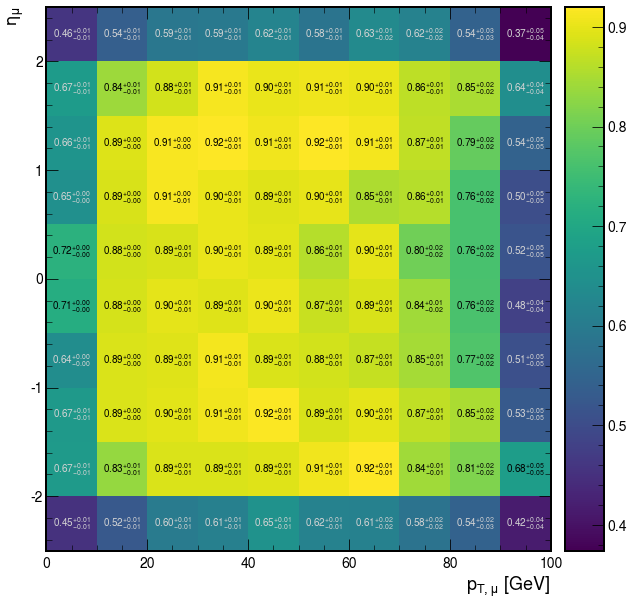

In [19]:
os.system('mkdir -p acceptance_upsilon')
os.system('rm -rf acceptance_upsilon/*')
os.system('rm -rf /eos/user/k/kmotaama/www/acceptance_upsilon')
fig = plt.figure()
for key in output:
    if key == 'details': continue
    os.system(f'mkdir -p acceptance_upsilon/{key}')
    for plot in output[key]:
        fig.clear()
        ax = fig.add_subplot()
        if len(output[key][plot].shape) == 1:
            log = False
            if '_pt' in plot: log = True
            create_plot1d(output[key][plot], log=log, ax=ax)
            fig = ax.get_figure()
            fig.savefig(f'acceptance_upsilon/{key}/{plot}.png')
        elif len(output[key][plot].shape) == 2:
            create_plot2d(output[key][plot], ax=ax)
            fig = ax.get_figure()
            fig.savefig(f'acceptance_upsilon/{key}/{plot}.png')

fig.clear()
ax = fig.add_subplot()
acceptance_plot(output['Reco_Upsilon']['Reco_Upsilon_ptxeta'], output['Gen_Upsilon']['Gen_Upsilon_ptxeta'], ax=ax)
ax.set_xlabel(r"$p_{T,\Upsilon}$ [GeV]")
ax.set_ylabel(r"$\eta_\Upsilon$")
fig.savefig(f'acceptance_upsilon/acceptance_upsilon.png')

fig.clear()
ax = fig.add_subplot()
reco_muon = output['Reco_Muon_lead']['Reco_Muon_lead_ptxeta'] + output['Reco_Muon_trail']['Reco_Muon_trail_ptxeta']
gen_muon = output['Gen_Muon_lead']['Gen_Muon_lead_ptxeta'] + output['Gen_Muon_trail']['Gen_Muon_trail_ptxeta']
acceptance_plot(reco_muon, gen_muon, ax=ax)
ax.set_xlabel(r"$p_{T,\mu}$ [GeV]")
ax.set_ylabel(r"$\eta_\mu$")
fig.savefig(f'acceptance_upsilon/acceptance_muon.png')

os.system(f'cp -r acceptance_upsilon /eos/user/k/kmotaama/www/.')

In [5]:
import uproot

f = uproot.open(files[0])
events = f['Events'].arrays()

GenPart = ak.zip({**get_vars_dict(events, gen_part_cols)}, with_name="PtEtaPhiMLorentzVector")
        
# Muon
GenPart_Muon = GenPart[(np.absolute(GenPart.pdgId) == 13) & (GenPart.genPartIdxMother > -1)]
GenPart_Muon = ak.combinations(GenPart_Muon, 2)
GenPart_Muon = GenPart_Muon[GenPart_Muon.slot0.genPartIdxMother == GenPart_Muon.slot1.genPartIdxMother]
leading_mu = (GenPart_Muon.slot0.pt > GenPart_Muon.slot1.pt)
GenPart_Muon_lead = ak.where(leading_mu, GenPart_Muon.slot0, GenPart_Muon.slot1)
GenPart_Muon_trail = ak.where(~leading_mu, GenPart_Muon.slot0, GenPart_Muon.slot1)

# Upsilon
GenPart_Ups = GenPart[GenPart_Muon.slot0.genPartIdxMother]

Dimu = ak.zip({**get_vars_dict(events, dimu_cols)}, with_name="PtEtaPhiMCandidate")
Muon = ak.zip({**get_vars_dict(events, muon_cols)}, with_name="PtEtaPhiMCandidate")

Muon = ak.zip({'0': Muon[Dimu.t1muIdx], '1': Muon[Dimu.t2muIdx]})

for i0 in range(len(GenPart_Ups)):
    print(i0)
    print('GenParticles')
    for i1 in range(len(GenPart_Ups[i0])):
        print_candidate(GenPart_Ups[i0][i1])
        print('\t', end='')
        print_candidate(GenPart_Muon_lead[i0][i1])
        print('\t', end='')
        print_candidate(GenPart_Muon_trail[i0][i1])
        print(f'Mom 4-momentum: {build_4mom_string(GenPart_Muon_trail[i0][i1]+GenPart_Muon_lead[i0][i1])}')
        print('')
    print('Reco')
    for i1 in range(len(Dimu[i0])):
        print(f'Dimu: {build_4mom_string(Dimu[i0][i1])}')
    for i1 in range(len(Muon.slot0[i0])):
        print('\t', end='')
        print(f'Muon 0: {build_4mom_string(Muon.slot0[i0][i1])}')
        print('\t', end='')
        print(f'Muon 1: {build_4mom_string(Muon.slot1[i0][i1])}')



0
GenParticles
PDGId: 553, motherId: -999, n_daughters: 2, status: 2, 4-momentum (pt, eta, phi, mass): (5.77,3.65,-1.16,9.46)
	PDGId: 13, motherId: 0, n_daughters: 0, status: 1, 4-momentum (pt, eta, phi, mass): (5.82,2.42,-1.55,0.11)
	PDGId: -13, motherId: 0, n_daughters: 0, status: 1, 4-momentum (pt, eta, phi, mass): (2.24,4.25,0.24,0.11)
Mom 4-momentum: (5.77,3.65,-1.16,9.46)

PDGId: 553, motherId: -999, n_daughters: 2, status: 2, 4-momentum (pt, eta, phi, mass): (5.77,-3.65,1.98,9.46)
	PDGId: 13, motherId: 1, n_daughters: 0, status: 1, 4-momentum (pt, eta, phi, mass): (7.54,-3.27,2.26,0.11)
	PDGId: -13, motherId: 1, n_daughters: 0, status: 1, 4-momentum (pt, eta, phi, mass): (2.55,-2.27,-0.21,0.11)
Mom 4-momentum: (5.77,-3.65,1.98,9.46)

Reco
1
GenParticles
PDGId: 553, motherId: -999, n_daughters: 2, status: 2, 4-momentum (pt, eta, phi, mass): (43.00,1.06,-0.64,9.46)
	PDGId: -13, motherId: 0, n_daughters: 0, status: 1, 4-momentum (pt, eta, phi, mass): (32.94,1.10,-0.74,0.11)
	PDGId:

In [89]:

for i0 in range(len(Dimu)):
    print(i0)
    for i1 in range(len(Dimu[i0])):
        print(f'Dimu: {build_4mom_string(Dimu[i0][i1])}')
    for i1 in range(len(Muon.slot0[i0])):
        print('\t', end='')
        print(f'Muon 0: {build_4mom_string(Muon.slot0[i0][i1])}')
        print('\t', end='')
        print(f'Muon 1: {build_4mom_string(Muon.slot1[i0][i1])}')
        

0
1
Dimu: (42.56,-1.06,2.50,9.37)
Dimu: (42.24,1.05,-0.63,9.38)
	Muon 0: (19.30,-1.26,2.60,0.11)
	Muon 1: (23.23,-0.86,2.42,0.11)
Mom: (42.37,-0.72,2.50,9.32)
	Muon 0: (32.10,1.10,-0.74,0.11)
	Muon 1: (10.93,0.84,-0.32,0.11)
Mom: (42.29,0.72,-0.63,9.39)
2
Dimu: (89.56,0.65,0.92,9.56)
	Muon 0: (52.35,0.73,0.93,0.11)
	Muon 1: (36.76,0.52,0.89,0.11)
Mom: (89.08,0.54,0.92,9.51)
3
Dimu: (90.10,-1.15,-2.65,9.42)
Dimu: (91.53,1.15,0.49,9.57)
	Muon 0: (47.60,-1.04,-2.64,0.11)
	Muon 1: (43.06,-1.25,-2.66,0.11)
Mom: (90.65,-0.75,-2.65,9.48)
	Muon 0: (51.54,1.21,0.56,0.11)
	Muon 1: (39.88,1.06,0.40,0.11)
Mom: (91.16,0.75,0.49,9.53)
4
Dimu: (90.77,1.00,-1.96,9.43)
	Muon 0: (77.78,0.98,-2.00,0.11)
	Muon 1: (13.58,1.06,-1.72,0.11)
Mom: (90.90,0.70,-1.96,9.44)
5
6
Dimu: (47.36,-1.09,-0.51,9.47)
	Muon 0: (18.60,-1.22,-0.71,0.11)
	Muon 1: (29.47,-0.99,-0.38,0.11)
Mom: (47.44,-0.73,-0.51,9.49)
7
8
9
10
Dimu: (73.05,-1.93,2.08,9.50)
Dimu: (72.67,1.93,-1.06,9.37)
	Muon 0: (65.36,-1.96,2.08,0.11)
	Muon 1: 

<AxesSubplot:xlabel='$p_{T,Reco \\Upsilon}$ [GeV]', ylabel='$|\\eta_{Reco \\Upsilon}|'>

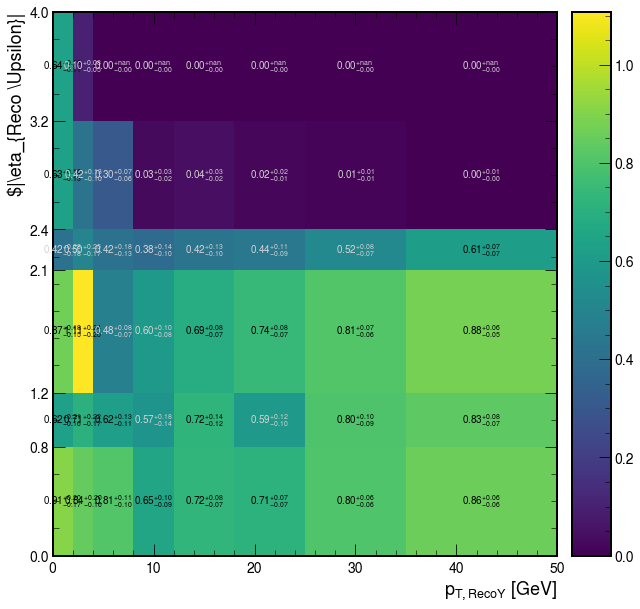

In [26]:
fig = plt.figure()
fig.clear()
ax = fig.add_subplot()
reco_upsilon = output['Reco_Upsilon']['Reco_Upsilon_ptxmodeta']
gen_upsilon = output['Gen_Upsilon']['Gen_Upsilon_ptxmodeta']
acceptance_plot(reco_upsilon, gen_upsilon, ax=ax, with_labels=True)

<AxesSubplot:xlabel='$p_{T,Gen \\Upsilon}$ [GeV]'>

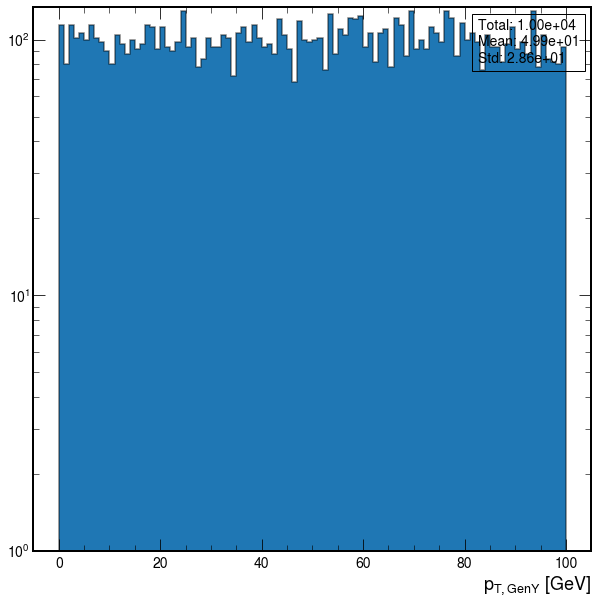

In [54]:
fig = plt.figure()
fig.clear()
ax = fig.add_subplot()

create_plot1d(output['Gen_Upsilon']['Gen_Upsilon_pt'], ax=ax, log=True)

AttributeError: 'NoneType' object has no attribute 'ticklabel_format'

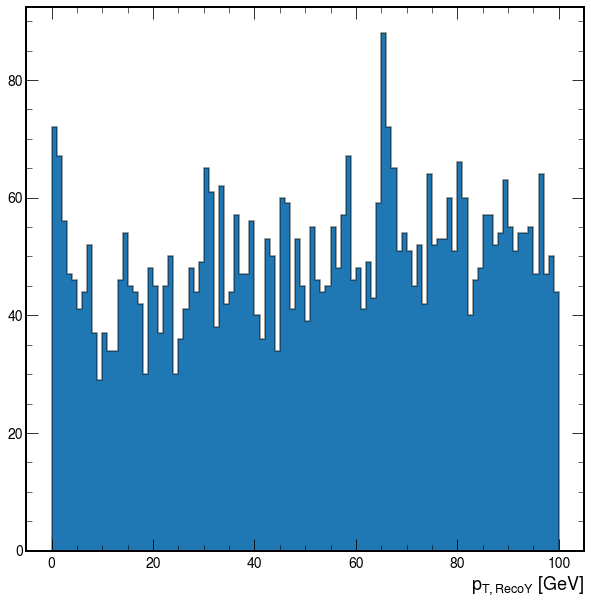

In [9]:
create_plot1d(output['Reco_Upsilon']['Reco_Upsilon_pt'])

AttributeError: 'NoneType' object has no attribute 'ticklabel_format'

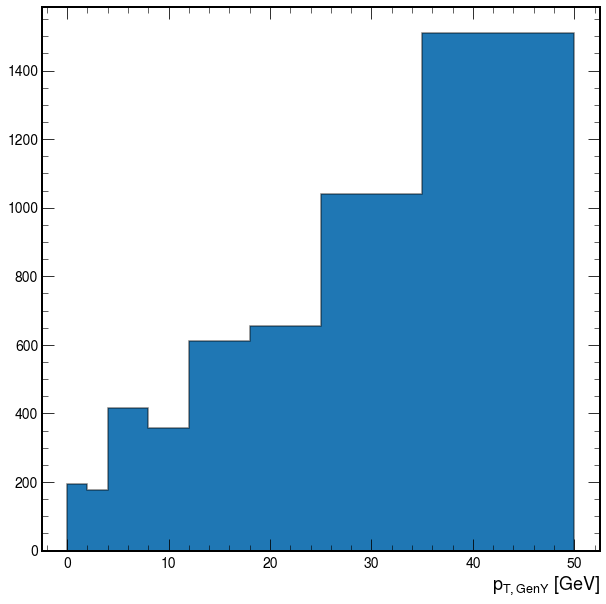

In [9]:
create_plot1d(output['Gen_Upsilon']['Gen_Upsilon_pt_var'])

In [21]:
x = reco_upsilon.axes[0]
len(x.centers)

8